In [20]:
# Base Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Algorithm imports
from sklearn.model_selection import train_test_split

In [3]:
# Global variables
HOUSING_PATH = "datasets/housing/"

In [16]:
# Plot settings
%matplotlib inline
sns.set()

In [4]:
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [7]:
housing = load_housing_data()

In [8]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There is only one categorical variable - `ocean_proximity`. We can tabulate it to see the class distribution

In [10]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028A6E2D2160>,
      dtype=object)

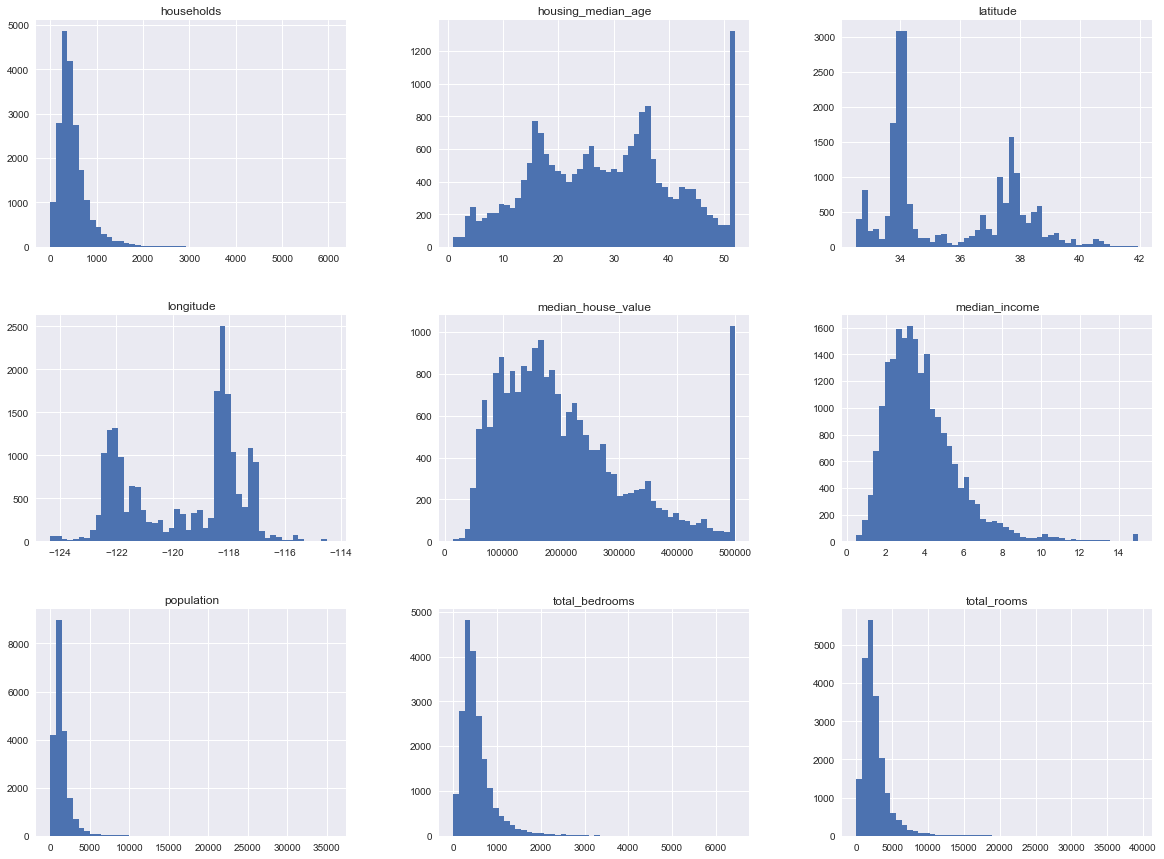

In [17]:
housing.hist(bins = 50, figsize = (20, 15))

In [19]:
housing_train, housing_test = train_test_split(housing, test_size = 0.2, random_state = 20130810)

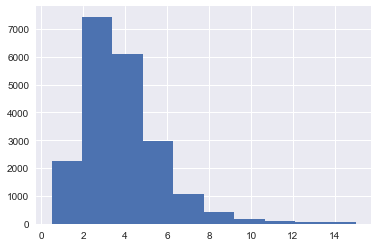

In [22]:
housing['median_income'].hist(bins = 10)

In [25]:
housing['income_cat'] = np.ceil(housing['median_income']/1.5)

# .where method implements the if-then condition; if the condition is true its value is used otherwise
# the specified value is used

housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

In [26]:
housing['income_cat'].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

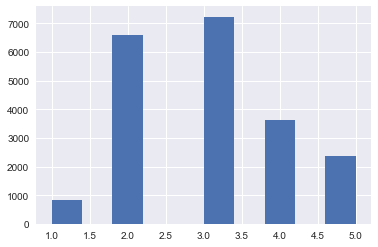

In [27]:
housing['income_cat'].hist()